In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import scipy.stats
import scipy.optimize
import numdifftools as nd
from numdifftools import Jacobian, Hessian
sns.set()

In [8]:
#!pip install numdifftools

In [2]:
pd.set_option('precision', 2)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [166]:
# Importerer data skabt med "Bresnahan - data"
df = pd.read_csv("https://raw.githubusercontent.com/Oliverkobaek/thesis_2020/master/Bresnahan/Bresnahan_data_full_l%C3%A6s%C3%B8.csv")
df = df.drop(['Unnamed: 0'], axis=1)

In [176]:
# Her har implementerert forskellige udgaver af data

### Med og uden storbyer ###

# Fjerner København
#
#storbyer = [101, 147, 461, 751, 851]
  
#for i in storbyer:
#    df = df[df['Kommune'] != i]
  
#df = df[df['Kommune'] != 101]
#df = df[df['Kommune'] != 147]


### Forskellige år ###

# Vi har primært fokuseret på perioden 2015-2018, da denne passer bedst på urestrikteret Bresnahan
    

df = df[(df['År'] != 2008) & (df['År'] !=  2009) & (df['År'] !=  2010) & (df['År'] !=  2011)& (df['År'] !=  2012)& (df['År'] !=  2013)& (df['År'] !=  2014)] #& (df['År'] !=  2015)
#df = df[(df['År'] == 2017)] & (df['År'] !=  2015)
#df = df[(df['År'] != 2015) & (df['År'] !=  2016) & (df['År'] !=  2017) & (df['År'] !=  2018)]


### Forskellige skaleringer ###

# Vi har forsøgt skaleringer som i Bresnahan, Schauman og andet - nogle skaleringer virker ikke til at konvergerer i vores optimizer

df['logbefolkning'] = np.log(df['Befolkning'])
df['logmarkedsvalue'] = df['markedsvaerdix']/100000 #np.log()
df['logindkomst'] = df['samlet_ind']/100000 #np.log()

In [177]:
df

,Kommune,ALDER,d65,d17,samlet_ind,Besk,Besk1864,DK,Befolkning,markedsvaerdix,yderkom,antal_apo,År,logbefolkning,logmarkedsvalue,logindkomst
679,101,35.38,0.10,0.18,203077.10,0.54,0.71,0.76,591481,1768450.97,0,27,2015,13.29,17.68,2.03
680,147,38.84,0.17,0.17,230605.31,0.52,0.75,0.82,104481,2245134.86,0,5,2015,11.56,22.45,2.31
681,151,41.36,0.21,0.22,185774.19,0.46,0.74,0.85,48224,1652916.86,0,4,2015,10.78,16.53,1.86
682,153,40.83,0.19,0.21,162131.78,0.45,0.69,0.69,35322,1704673.21,0,3,2015,10.47,17.05,1.62
683,155,43.41,0.24,0.23,234501.33,0.48,0.80,0.92,14142,2232076.06,0,1,2015,9.56,22.32,2.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1066,860,43.69,0.23,0.20,170647.52,0.48,0.76,0.92,64665,1131648.25,0,7,2018,11.08,11.32,1.71
1074,825,51.80,0.36,0.14,156511.19,0.47,0.74,0.92,1817,547791.16,1,0,2015,7.50,5.48,1.57
1075,825,52.28,0.37,0.13,158750.32,0.47,0.75,0.92,1793,489477.15,1,0,2016,7.49,4.89,1.59
1076,825,52.95,0.38,0.13,165000.49,0.48,0.75,0.91,1807,570316.13,1,0,2017,7.50,5.70,1.65


In [178]:
# Opsætning af log-likelihood


def V(df, Ni, alpha=np.ones(5), beta=np.ones(5)):
    """Variabel profit funktion
    df: data
    Ni: Antal apoteker i markedet
    alpha: alpha parametrer
    beta: beta parametrer
    """
    # opsætning af alpha parametrer alt efter om der er 0-5 incumbents
    n = np.min([5, Ni])
    a = 0
    for i in range(1,n):
        a = a + alpha[i]
    
# Her konstruerer vi Z af de kontrol variable vi har data på
    Z = np.c_[df.d65, df.d17, df.logindkomst, df.Besk1864, df.DK]

# Mulighed for at implementerer W i variabel profit
    # W = df.LANDV
    # X = np.c_[W, Z]

    X = np.c_[Z]
        
    profit = alpha[0] + X @ beta - a
    return profit

def F(df, Ni, gamma=np.ones(5)):
    """Fixed cost funktion
    df: data
    Ni: Antal apoteker i markedet
    gamma: gamma parametrer
    """
    # opsætning af gamma parametrer alt efter om der er 0-5 incumbents
    n = np.min([5, Ni])
    g = 0
    for i in range(1,n):
        g = g + gamma[i]

    fixed_cost = gamma[0] + gamma[5]*df.logmarkedsvalue + g
    return fixed_cost

# Vi har en meget reduceret S(Y, lam) funktion forhold til Bresnahan, da vi ikke har befolkningstilvækst, pendler og nærliggende byer med
def S_func(df, lam): #, lam - Vi har forsøgt at kører med lam = 1 som i Bresnahan
    """Antal forbrugere funktion
    df: data
    lam: lam parametrer
    """
    S =   lam * df.logbefolkning
    return S


def neg_log_lik(theta=np.ones(17), market='antal_apo', df=df):
    lam = theta[0]
    beta = theta[1:6]
    alpha = theta[6:11]
    gamma = theta[11:17]
#    my = theta[17]
#    beta = theta[0:5]
#    alpha = theta[5:10]
#    gamma = theta[10:16]
    
    
    Phi = scipy.stats.norm.cdf
    
    S = S_func(df, lam) #, lam

    
    P = [0] * 6
    Pi_bar = lambda N: S * V(df, N, alpha=alpha, beta=beta) - F(df, N, gamma=gamma)
    P[0] = np.log( 1 - Phi(Pi_bar(0)) )
    P[5] = np.log( Phi(Pi_bar(5)) )
    for i in range(1,5):
        P[i] = np.log( Phi(Pi_bar(i)) - Phi(Pi_bar(i+1)) )

        
    for i in range(6):
        P[i][P[i] == -np.inf] = -100000000
    log_lik = 0 
    for i in range(5):
        log_lik = log_lik + np.sum(P[i] * (df[market] == i))
    log_lik = log_lik + np.sum(P[5] * (df[market] >= 5))
    return -log_lik


def theta_to_param_dict(theta):
    lam = theta[0]
    beta = theta[1:6]
    alpha = theta[6:11]
    gamma = theta[11:17]
#    my = theta[17]
#    beta = theta[0:5]
#    alpha = theta[5:10]
#    gamma = theta[10:16]
    
    
    d = {'lam': lam, 'beta': beta, 'alpha': alpha, 'gamma': gamma, 'theta': theta } #'my': my,
    return d

In [179]:
# Hurtig test om det kører
theta0 = np.ones(17) * 0.1
neg_log_lik(df=df, theta=theta0)

1346.721885901282

In [180]:
%%time
# Opsætning af bounds for parametrer 
#  - vi vil ikke have negative alpha 1-5 eller gamma 1-5

ba = [-np.inf] * 6
bb = [0] * 10
lower_bounds = [*ba, *bb, -np.inf]
upper_bounds = [np.inf] * 17
bounds = list(zip(lower_bounds, upper_bounds))

# Optimering af log-likelihood (tager ca. 2 min)
# Start gæt er 0.1 for alle parametrer
theta0 = np.ones(17) * 0.1

nll = lambda theta: neg_log_lik(theta=theta, df=df)
out = scipy.optimize.minimize(nll, theta0, bounds=bounds,
    options={'disp': False, 'maxiter': 10000}
    )

C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log


Wall time: 19.9 s


In [181]:
out

      fun: 478.7061936641023
 hess_inv: <17x17 LbfgsInvHessProduct with dtype=float64>
      jac: array([-113.48685121,  -29.43899631,   -6.28162411, -144.22248569,
        -49.33897912,  -70.54663911,  -79.77881751,   92.84677276,
         50.14110798,  120.24374314,   81.23802786,    4.47525395,
          7.33901402,    1.48887125,   13.95885079,    9.20495609,
        216.27103592])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1260
      nit: 56
   status: 0
  success: True
        x: array([ 0.65647408, -2.88542427, -0.10067677,  0.1627941 , -1.54652838,
        1.05254497,  1.87876807,  0.00463175,  0.        ,  0.0612556 ,
        0.04235205,  3.28062836,  3.28035405,  0.92088514,  0.32617598,
        0.27893406,  0.07156334])

In [182]:
# Beregning af standard errors til parametrerne:
# Vi anvender numdifftools

Hfun = nd.Hessian(nll, full_output=True)
hessian_nd, info= Hfun(out['x'])
se = np.sqrt(np.diag(np.linalg.inv(hessian_nd)))

results = pd.DataFrame({'parameters':out['x'],'std err':se})
results.index=['lambda - befolkning','beta_1 - Andel over 65','beta_2 - Andel under 17','beta_3 - indkomst','beta_4 - Beskæftiget mellem 18-64','beta_5 - Andel med udenlandsk baggrund','alpha_1','alpha_2','alpha_3','alpha_4','alpha_5','gamma_1','gamma_2','gamma_3','gamma_4','gamma_5', 'gamma_6 - Markedsværdi'] #,'gamma6'  


C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:55: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in log
C:\Users\Oliver\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


In [183]:
results

,parameters,std err
lambda - befolkning,0.66,nan
beta_1 - Andel over 65,-2.89,0.50
beta_2 - Andel under 17,-0.10,0.93
beta_3 - indkomst,0.16,0.07
beta_4 - Beskæftiget mellem 18-64,-1.55,0.42
beta_5 - Andel med udenlandsk baggrund,1.05,0.20
alpha_1,1.88,1.09
alpha_2,0.00,1.11
alpha_3,0.00,0.36
alpha_4,0.06,0.33


In [184]:
se

array([       nan, 0.49633777, 0.93376073, 0.06784275, 0.42086398,
       0.19612377, 1.08896746, 1.11480096, 0.36403264, 0.33197016,
       0.39451774, 5.84257171, 5.99034759, 2.45528275, 2.31661203,
       2.78762187, 0.02881246])

In [185]:
hat_theta = theta_to_param_dict(out.x)

In [186]:
hat_theta

{'lam': 0.6564740789792425,
 'beta': array([-2.88542427, -0.10067677,  0.1627941 , -1.54652838,  1.05254497]),
 'alpha': array([1.87876807, 0.00463175, 0.        , 0.0612556 , 0.04235205]),
 'gamma': array([3.28062836, 3.28035405, 0.92088514, 0.32617598, 0.27893406,
        0.07156334]),
 'theta': array([ 0.65647408, -2.88542427, -0.10067677,  0.1627941 , -1.54652838,
         1.05254497,  1.87876807,  0.00463175,  0.        ,  0.0612556 ,
         0.04235205,  3.28062836,  3.28035405,  0.92088514,  0.32617598,
         0.27893406,  0.07156334])}

In [187]:
# Beregning af S_1 - S_5
def calcS(df, theta):
    d = theta_to_param_dict(theta)
    S_grid = np.zeros(5)
    
    dfm = df.mean()
    for i in range(5):
        n = i + 1
        S_grid[i] = F(dfm, n, d['gamma']) / V(dfm, n, d['alpha'], d['beta'])
        # Vi har indsat print fordi vi havde problemer med negative værdier
        print(F(dfm, n, d['gamma']) )
        print(V(dfm, n, d['alpha'], d['beta']))
    return S_grid

S_vals = calcS(df, out.x)

4.228786495848466
[1.30352637]
7.50914054121737
[1.29889462]
8.43002568519968
[1.29889462]
8.756201660366251
[1.23763902]
9.0351357227572
[1.19528697]


In [189]:
table5A_left = pd.DataFrame({'Apoteker':S_vals}).T
table5A_left.columns = ['S_1', 'S_2', 'S_3', 'S_4', 'S_5']
table5A_left

,S_1,S_2,S_3,S_4,S_5
Apoteker,3.24,5.78,6.49,7.07,7.56


In [190]:
a = [S_vals[i+1]/S_vals[i] * ((i+1)/(i+2)) for i in range(4)]
table5A_right = pd.DataFrame(a).T
table5A_right.columns = ['s2/s1', 's3/s2', 's4/s3', 's5/s4']

In [191]:
table5A_right

,s2/s1,s3/s2,s4/s3,s5/s4
0,0.89,0.75,0.82,0.85


In [192]:
SN_S5_ratio = S_vals[5-1]* np.arange(1,5+1) / (S_vals * 5)

In [193]:
SN_S5_ratio

array([0.46601141, 0.5230054 , 0.69880944, 0.85473349, 1.        ])

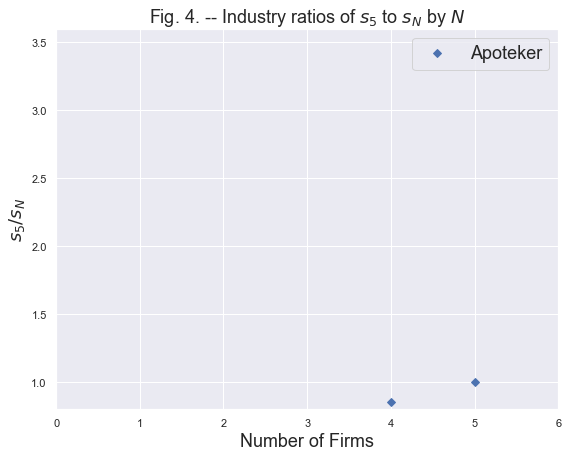

In [194]:
BIG = 18
fig = plt.figure(figsize=(9,7))
plt.plot([1,2,3,4,5], SN_S5_ratio, 'D', label='Apoteker')
ax = fig.get_axes()[0]
plt.legend(fontsize=BIG)
plt.xlim(0,6)
plt.ylim(0.8, 3.6)
plt.title('Fig. 4. -- Industry ratios of $s_5$ to $s_N$ by $N$', fontsize=BIG)
plt.xlabel('Number of Firms', fontsize=BIG)
plt.ylabel('$s_5/s_N$', fontsize=BIG);
# ax.set_ylabel('$s_5/s_N$', fontsize=40)